# Score-Based Generative Modeling

### Reference

[Yang Song, Tutorial on Score-Based Generative Modeling](https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing#scrollTo=qW1HaPZb9gDM) <br/>
[Yang Song et al., Generative Modeling by Estimating Gradients of the Data Distribution](https://arxiv.org/pdf/1907.05600.pdf) <br/>
[Yang Song et al., Score-Based Generative Modeling through Stochastic Differential Equations](https://arxiv.org/pdf/2011.13456.pdf)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
from tqdm import tqdm

In [ ]:
n_epochs = 50
batch_size = 32

lr = 1e-4

In [ ]:
dataset = CIFAR10(root="./data", transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Files already downloaded and verified


In [ ]:
print(dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


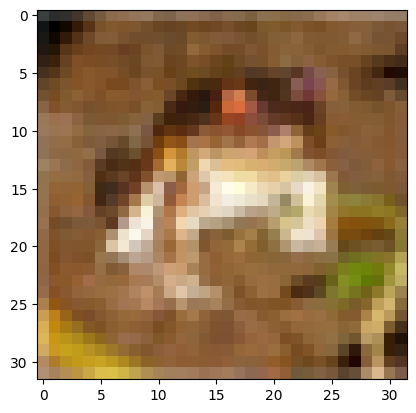

In [ ]:
img = next(iter(dataset))[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [ ]:
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        x_result = self.dense(x)
        # Reshape to (batch_size, channel, img_height, img_width)
        return x_result[..., None, None]

In [ ]:
class ScoreNet(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256, verbose=False):
        """
        :param marginal_prob_std: standard deviation of the perturbation kernel p_{0t}(x(t) | x(0))
        """
        super().__init__()
        self.embed = nn.Sequential(
            GaussianFourierProjection(embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding Layers
        self.linear = nn.Linear(3, 1)
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        
        self.conv2 = nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], kernel_size=3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], kernel_size=3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding Layers
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], kernel_size=3, stride=2, bias=False)
        self.tdense4 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] * 2, channels[1], kernel_size=3, stride=2, bias=False)
        self.tdense3 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] * 2, channels[0], kernel_size=4, stride=2, bias=False)
        self.tdense2 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0] * 2, 3, kernel_size=3, stride=1, padding=1)

        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

        self.verbose = verbose

    def forward(self, x, t):
        embed = self.act(self.embed(t))
        
        # Encoding Block
        h1 = self.conv1(x)
        h1 += self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        if self.verbose:
          print("h1 shape:", h1.shape)

        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        if self.verbose:
          print("h2 shape:", h2.shape)

        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        if self.verbose:
          print("h3 shape:", h3.shape)

        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        if self.verbose:
          print("h4 shape:", h4.shape)

        # Decoding Block
        h = self.tconv4(h4)
        h += self.tdense4(embed)
        h = self.act(self.tgnorm4(h))
        if self.verbose:
          print("h shape:", h.shape)

        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.tdense3(embed)
        h = self.act(self.tgnorm3(h))
        if self.verbose:
          print("h3 shape:", h3.shape)
          print("h shape:", h.shape)

        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.tdense2(embed)
        h = self.act(self.tgnorm2(h))
        if self.verbose:
          print("h2 shape:", h2.shape)
          print("h shape:", h.shape)

        h = self.tconv1(torch.cat([h, h1], dim=1))
        if self.verbose:
          print("h1 shape:", h1.shape)
          print("h shape:", h.shape)

        # (batch_size, channel, img_height, img_width)
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [ ]:
# Apple M series GPU
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
    
# Nvidia GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [ ]:
def marginal_prob_std(t, sigma=25.0):
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma ** (2 * t) - 1.) / 2. * np.log(sigma))

def diffusion_coefficient(t, sigma=25.0):
    return torch.tensor(sigma ** t, device=device)

In [ ]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    # Prevent to sample t=0 and t=1
    random_t = torch.rand(x.shape[0], device=device) * (1. - eps) + eps
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z) ** 2, dim=(1,2,3)))
    return loss

In [ ]:
# Upload model to GPU
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std))
score_model = score_model.to(device)


In [ ]:
print(score_model)

DataParallel(
  (module): ScoreNet(
    (embed): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (linear): Linear(in_features=3, out_features=1, bias=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (dense1): Dense(
      (dense): Linear(in_features=256, out_features=32, bias=True)
    )
    (gnorm1): GroupNorm(4, 32, eps=1e-05, affine=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense2): Dense(
      (dense): Linear(in_features=256, out_features=64, bias=True)
    )
    (gnorm2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense3): Dense(
      (dense): Linear(in_features=256, out_features=128, bias=True)
    )
    (gnorm3): GroupNorm(32, 128, eps=1e-05, affine=True)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False

In [ ]:
optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm(range(n_epochs), desc="Training")

for epoch in tqdm_epoch:
    sum_loss = 0.
    num_items = 0
    for x, _ in dataloader:
        x = x.to(device)
        loss = loss_fn(score_model, x, marginal_prob_std)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    
    tqdm_epoch.set_description("Average Loss: {:.4f}".format(sum_loss / num_items))
    torch.save(score_model.state_dict(), "checkpoint.pth")

Training:   0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-10-730d40cd5817>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
Average Loss: 17.4357: 100%|██████████| 50/50 [15:56<00:00, 19.13s/it]


In [ ]:
def Euler_Maruyama_sampler(score_model, marginal_prob_std, diffusion_coefficient,
                           batch_size=64, num_steps=10000, device=device, eps=1e-3):
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 3, 32, 32, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]

    x = init_x

    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            gt = diffusion_coefficient(batch_time_step)
            mean_x = x + (gt**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + gt[:, None, None, None] * torch.sqrt(step_size) * torch.randn_like(mean_x)

    return mean_x

In [ ]:
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64, 
               num_steps=10000, 
               snr=0.16,                
               device=device,
               eps=1e-3):
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 3, 32, 32, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean

In [ ]:
from torchvision.utils import make_grid

checkpoint = torch.load("checkpoint.pth", map_location=device)
score_model.load_state_dict(checkpoint)

sample_batch_size = 64
samples = pc_sampler(score_model, marginal_prob_std, diffusion_coefficient, sample_batch_size, device=device)

<ipython-input-10-730d40cd5817>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-10-730d40cd5817>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma ** t, device=device)
100%|██████████| 10000/10000 [01:23<00:00, 119.24it/s]


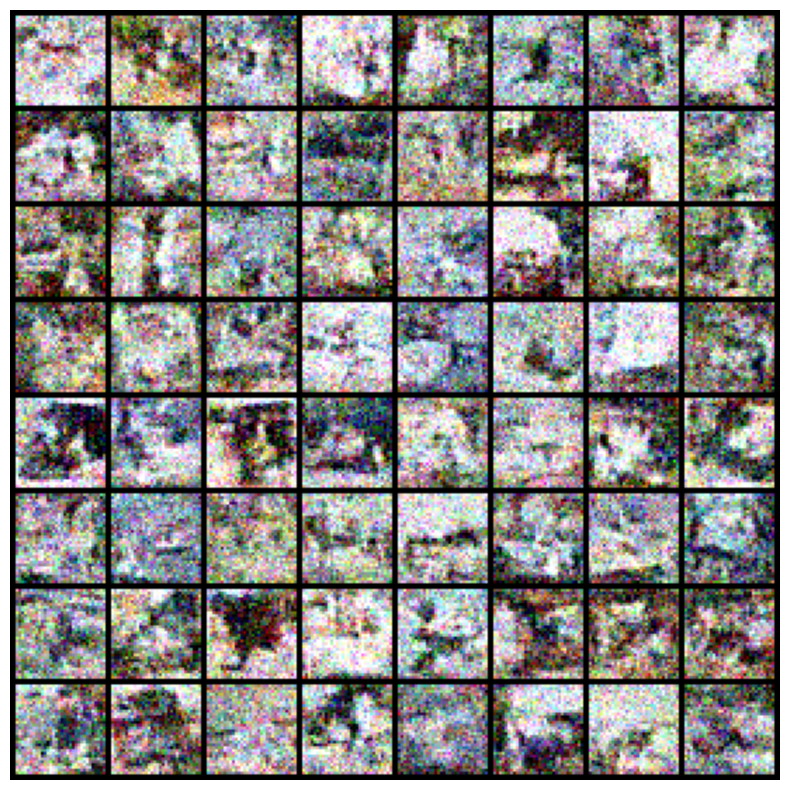

In [ ]:
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))
# (channel, img_width, img_height)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).detach().cpu(), vmin=0., vmax=255.)
plt.show()